In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import sympy as sym
import laplacejumps as lj
from scipy import special

In [2]:
%matplotlib inline
mpl.style.use('seaborn-talk')
sym.init_printing()

In [3]:
x, y, z = sym.symbols('x y z', real=True)
gamma, sigma = sym.symbols('gamma sigma', real=True, positive=True)

In [4]:
Delta = sym.symbols('Delta', real=True, postive=True)

In [5]:
lap_dens = (sym.sqrt(2) * gamma)**(-1) * sym.exp(-sym.sqrt(2) * (abs(x) / gamma))

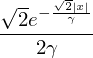

In [6]:
lap_dens

In [7]:
gauss_dens = (sym.sqrt(2 * sym.pi) * sigma)**(-1) * sym.exp(- (x**2 / sigma**2) / 2)

In [8]:
conv_dens = sym.integrate(lap_dens * gauss_dens.replace(x, z-x), (x, -sym.oo, sym.oo)).simplify().expand()

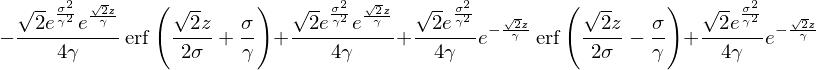

In [9]:
conv_dens

In [10]:
log_conv_dens = sym.log(conv_dens).simplify()

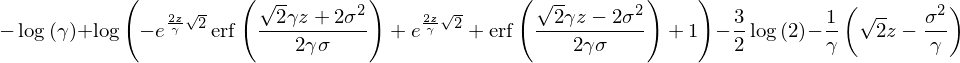

In [11]:
log_conv_dens

In the cell below, I compare the distributions of the jump and diffusion distributions and their convolutions.
In the convolution distribution, I set the standard deviations of the components equal to $2^{-1/2}$ in order to keep the variances of the three distributions the same.

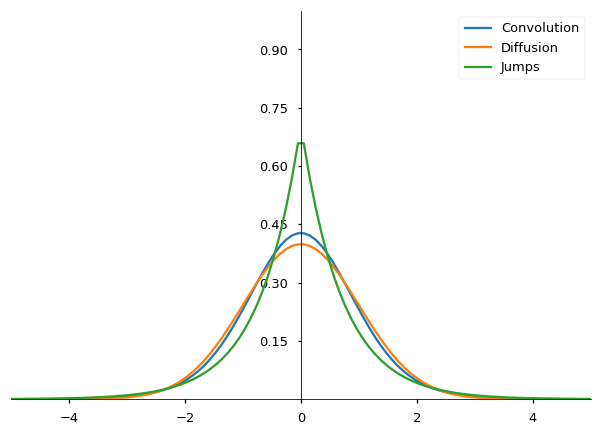

In [12]:
dens_comp_fig, dens_comp_ax = mpl.pyplot.subplots()
dens_comp_xvals = np.linspace(-5,5, 100)
dens_comp_ax.plot(dens_comp_xvals, [lj.lapgaussconv.pdf(x, sigma=2**-.5, gamma=2**-.5) for x in dens_comp_xvals], 
                  label='Convolution')
dens_comp_ax.plot(dens_comp_xvals, list(map(sym.lambdify((x), gauss_dens.replace(sigma,1)),dens_comp_xvals)),
                  label='Diffusion')
dens_comp_ax.plot(dens_comp_xvals, list(map(sym.lambdify((x), lap_dens.replace(gamma,1)),dens_comp_xvals)), 
                  label='Jumps')
dens_comp_ax.spines['left'].set_position('center')
dens_comp_ax.spines['top'].set_visible(False)
dens_comp_ax.spines['right'].set_visible(False)
dens_comp_ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=7, prune='lower'))
dens_comp_ax.set_ylim([0,1])
dens_comp_ax.set_xlim([-5,5])
dens_comp_ax.legend()

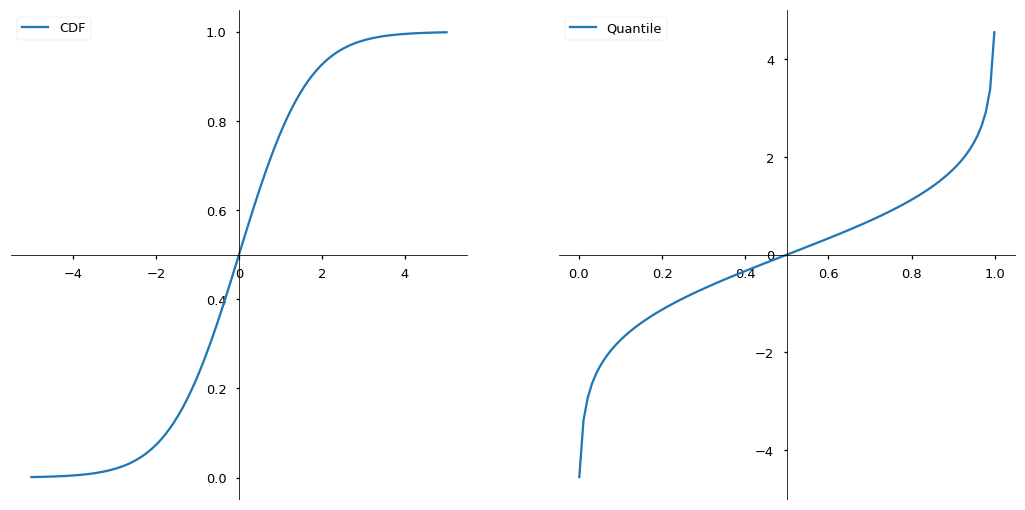

In [13]:
cdf_fig, (cdf_ax, quantile_ax) = mpl.pyplot.subplots(ncols=2, figsize=(18, 9))
cdf_xvals = np.linspace(-5,5, 100)
cdf_ax.plot(cdf_xvals,[lj.lapgaussconv.cdf(x,sigma=1,gamma=1) for x in cdf_xvals], label='CDF')
cdf_ax.spines['left'].set_position('center')
cdf_ax.spines['bottom'].set_position('center')
cdf_ax.spines['top'].set_visible(False)
cdf_ax.spines['right'].set_visible(False)
cdf_ax.legend()
quantile_xvals = np.linspace(.001,.999, 100)
quantile_ax.plot(quantile_xvals, [lj.lapgaussconv.ppf(x,sigma=1,gamma=1) for x in quantile_xvals],label='Quantile')
quantile_ax.spines['left'].set_position('center')
quantile_ax.spines['bottom'].set_position('center')
quantile_ax.spines['top'].set_visible(False)
quantile_ax.spines['right'].set_visible(False)
quantile_ax.legend()


In [14]:
integrand1 = (x**2 * lap_dens * gauss_dens.replace(x, z-x)).simplify()

In [15]:
integrand2 =  (x**2 * lap_dens.replace(x, z-x) * gauss_dens).simplify()

In [16]:
diffusion_var = (sym.integrate(integrand2, (x, -sym.oo, sym.oo))).simplify()

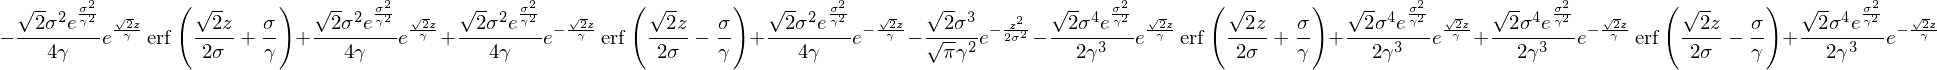

In [17]:
diffusion_var

In [18]:
jump_var = (sym.integrate(integrand1, (x, -sym.oo, sym.oo))).simplify()

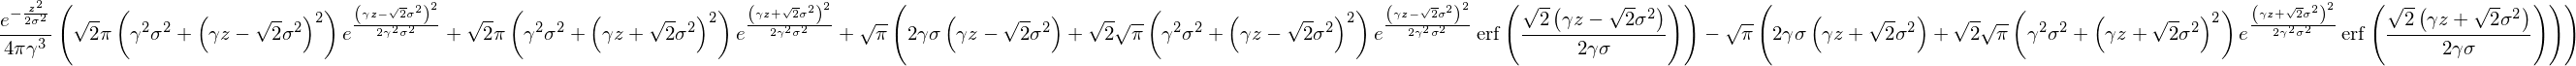

In [19]:
jump_var

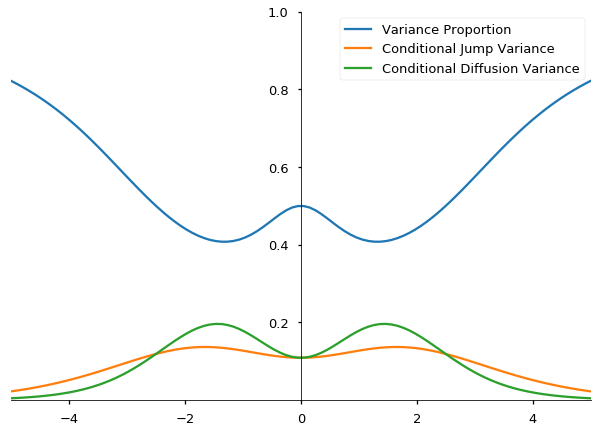

In [20]:
var_fig, var_ax = mpl.pyplot.subplots()
var_xvals = np.linspace(-5,5, 100)
std_args = {'sigma': 1, 'gamma':1}
var_ax.plot(var_xvals,[lj.jump_var_proportion(x,**std_args) for x in var_xvals], label='Variance Proportion')
var_ax.plot(var_xvals,[lj.jump_cond_var(x,**std_args) for x in var_xvals], label='Conditional Jump Variance')
var_ax.plot(var_xvals,[lj.diffusion_cond_var(x,**std_args) for x in var_xvals],
            label='Conditional Diffusion Variance')
var_ax.spines['left'].set_position('center')
var_ax.spines['top'].set_visible(False)
var_ax.spines['right'].set_visible(False)
var_ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=5, prune='lower'))
var_ax.set_ylim([0,1])
var_ax.set_xlim([-5,5])
var_ax.legend()

In this section I switch to computing the variance of the laplace part conditional on being greater than z.  (I.e. the variance of the expected shortfall.)

I split the integral into three parts, so I can remove the absolute value in the definition of the laplace density.

\begin{align*}
&\phantom{=} Var(x | x + y > z) \\
&= E[x^2 | x + y > z] - E[x | x + y > z]^2 \\ 
&= \int_{-\infty}^{\infty} \int_{z-y}^{\infty} x^2\mathcal{l}(x)  \phi(y) dx dy 
    - \left(\int_{-\infty}^{\infty} \int_{z-y}^{\infty} x\mathcal{l}(x)  \phi(y) dx dy \right)^2\\
&=  \int_{z}^{\infty} \int_{z-y}^{0} x^2 \mathcal{l}(x)  \phi(y) dx dy
 + \int_{z}^{\infty} \int_{0}^{\infty} x^2 \mathcal{l}(x)  \phi(y) dx dy
 +  \int_{-\infty}^{z} \int_{z-y}^{\infty} x^2 \mathcal{l}(x)  \phi(y) dx dy \\
 &\quad- \left(\int_{z}^{\infty} \int_{z-y}^{0} x \mathcal{l}(x)  \phi(y) dx dy
 + \int_{z}^{\infty} \int_{0}^{\infty} x \mathcal{l}(x)  \phi(y) dx dy
 +  \int_{-\infty}^{z} \int_{z-y}^{\infty} x \mathcal{l}(x)  \phi(y) dx dy \right)^2\\
\end{align*}

First I compure the expectation of the squared values.

In [23]:
es_integrand1 = (lap_dens.replace(abs(x), -x) * gauss_dens.replace(x, y)).simplify()
es_integrand2 = (lap_dens.replace(abs(x), x) * gauss_dens.replace(x, y)).simplify()

In [24]:
val_x1 = sym.integrate(sym.integrate(x**2 * es_integrand1, (x, z-y, 0)), (y, z, sym.oo)).simplify()
val_x2 = sym.integrate(sym.integrate(x**2 * es_integrand2, (x, 0, sym.oo)), (y, z, sym.oo))
val_x3 = sym.integrate(sym.integrate(x**2 * es_integrand2, (x, z-y,sym.oo)), (y, -sym.oo, z))
es_x_part = 2 * (val_x1 + val_x2 + val_x3).simplify()

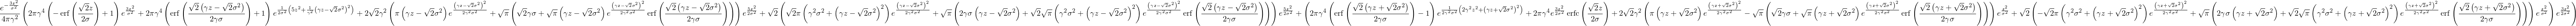

In [25]:
es_x_part

In [37]:
mean_x1 = sym.integrate(sym.integrate(x * es_integrand1, (x, z-y, 0)), (y, z, sym.oo)).simplify()
mean_x2 = sym.integrate(sym.integrate(x * es_integrand2, (x, 0, sym.oo)), (y, z, sym.oo))
mean_x3 = sym.integrate(sym.integrate(x * es_integrand2, (x, z-y,sym.oo)), (y, -sym.oo, z))
es_x_part_mean_squared = ((2 * (mean_x1 + mean_x2 + mean_x3))**2).simplify()

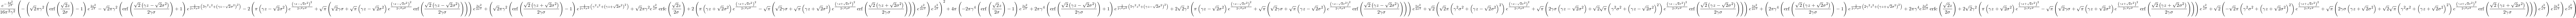

In [40]:
(es_x_part - es_x_part_mean_squared).simplify()

\begin{align*}
&\phantom{=} \int_{-\infty}^{\infty} \int_{z-y}^{\infty} y^2 \mathcal{l}(x)  \phi(y) dx dy \\
&=  \int_{z}^{\infty} \int_{z-y}^{0} y^2 \mathcal{l}(x)  \phi(y) dx dy
 + \int_{z}^{\infty} \int_{0}^{\infty} y^2 \mathcal{l}(x)  \phi(y) dx dy
 +  \int_{-\infty}^{z} \int_{z-y}^{\infty} x^2 \mathcal{l}(x)  \phi(y) dx dy \\
\end{align*}

In [26]:
val_y1 = sym.integrate(sym.integrate(y**2 * es_integrand1, (x, z-y, 0)), (y, z, sym.oo)).simplify()
val_y2 = sym.integrate(sym.integrate(y**2 * es_integrand2, (x, 0, sym.oo)), (y, z, sym.oo))
val_y3 = sym.integrate(sym.integrate(y**2 * es_integrand2, (x, z-y,sym.oo)), (y, -sym.oo, z))
es_y_part = 2 * (val_y1 + val_y2 + val_y3).simplify()

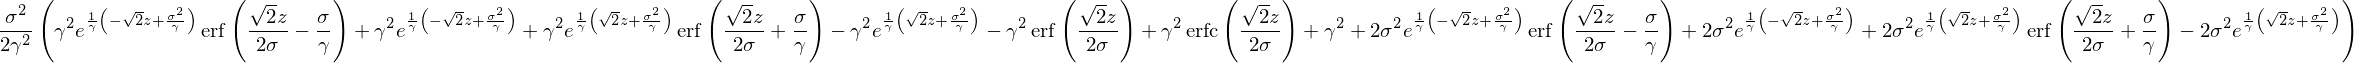

In [27]:
es_y_part

\begin{align*}
&\phantom{=} \int_{-\infty}^{\infty} \int_{z-y}^{\infty} 2 x y \mathcal{l}(x)  \phi(y) dx dy \\
&=  \int_{z}^{\infty} \int_{z-y}^{0} 2 x y \mathcal{l}(x)  \phi(y) dx dy
 + \int_{z}^{\infty} \int_{0}^{\infty}2 x y\mathcal{l}(x)  \phi(y) dx dy
 +  \int_{-\infty}^{z} \int_{z-y}^{\infty}2 x y \mathcal{l}(x)  \phi(y) dx dy \\
\end{align*}

In [28]:
val_xy1 = sym.integrate(sym.integrate(x * y * es_integrand1, (x, z-y, 0)), (y, z, sym.oo)).simplify()
val_xy2 = sym.integrate(sym.integrate(x * y * es_integrand2, (x, 0, sym.oo)), (y, z, sym.oo))
val_xy3 = sym.integrate(sym.integrate(x * y * es_integrand2, (x, z-y,sym.oo)), (y, -sym.oo, z))
es_xy_part = 2 * (val_xy1 + val_xy2 + val_xy3).simplify().collect(sigma)

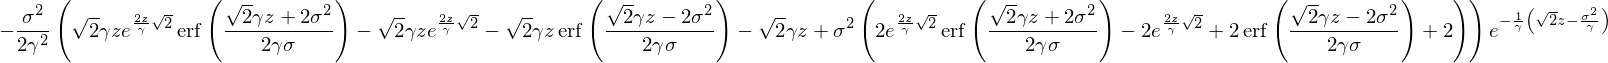

In [29]:
es_xy_part

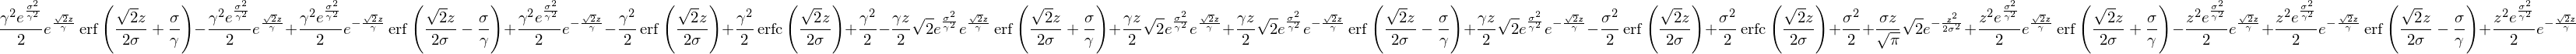

In [30]:
(es_x_part + 2 * es_xy_part + es_y_part).simplify()

The proportion of the variance of the return conditional on being greater than z driven by variability in the jumps

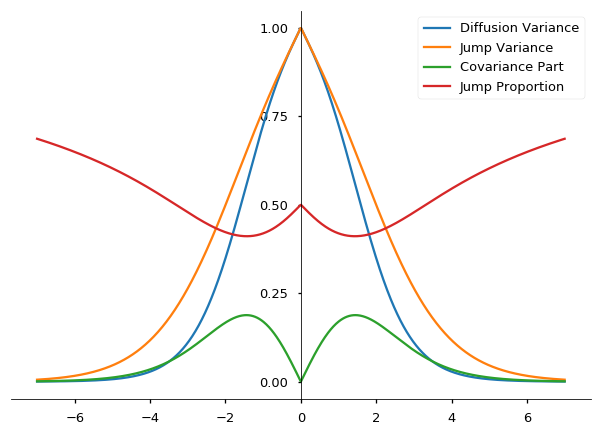

In [31]:
es_var_fig, es_var_ax = mpl.pyplot.subplots()
es_var_xvals = np.linspace(-7,7, 1000)
std_args = {'sigma': 1, 'gamma':1}
es_var_ax.plot(es_var_xvals,[lj.es_diffusion_variance(x,**std_args) for x in es_var_xvals], 
               label='Diffusion Variance')
es_var_ax.plot(es_var_xvals,[lj.es_jump_variance(x,**std_args) for x in es_var_xvals], 
               label='Jump Variance')
es_var_ax.plot(es_var_xvals,[lj.es_covariance_term(x,**std_args) for x in es_var_xvals], 
               label='Covariance Part')
es_var_ax.plot(es_var_xvals,[lj.es_jump_variance_prop(x,**std_args) for x in es_var_xvals], 
               label='Jump Proportion')
es_var_ax.spines['left'].set_position('center')
es_var_ax.spines['top'].set_visible(False)
es_var_ax.spines['right'].set_visible(False)
es_var_ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=5, prune='lower'))
es_var_ax.legend()